# DATASET FOR 330 ER GRAPHS

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit_aer.noise import pauli_error, NoiseModel, depolarizing_error
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector, Kraus, SuperOp
from qiskit_ibm_runtime import SamplerV2
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import Pauli

In [2]:
import networkx as nx

In [3]:
from qiskit.circuit import ParameterVector

In [4]:
import matplotlib.pyplot as plt

In [5]:
from qiskit.quantum_info import SparsePauliOp

In [6]:
from qiskit_ibm_runtime import EstimatorV2
estimator = EstimatorV2(backend=AerSimulator())

In [7]:
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [8]:
from qiskit_ibm_runtime import EstimatorV2
# Create an empty noise model
noise_model = NoiseModel()
 
# Add depolarizing error to Hadamard (h) and CNOT (cx) gates
error_1qubit = depolarizing_error(0.0001, 1)  # 0.01% error on single-qubit gates
error_2qubit = depolarizing_error(0.01, 2)  # 1% error on two-qubit gates

# Apply the errors to Hadamard and CNOT gates
noise_model.add_all_qubit_quantum_error(error_1qubit, ['x', 'sx'])  
noise_model.add_all_qubit_quantum_error(error_2qubit, ['cx', 'ecr', 'cz'])  
 
# Print noise model info
print(noise_model)
estimator = EstimatorV2(backend=AerSimulator(noise_model=noise_model))

NoiseModel:
  Basis gates: ['cx', 'cz', 'ecr', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'ecr', 'cx', 'cz', 'x']
  All-qubits errors: ['x', 'sx', 'cx', 'ecr', 'cz']


In [9]:
pm = generate_preset_pass_manager(optimization_level=3, basis_gates = ['x', 'sx', 'cx', 'rz'])

In [10]:
from scipy.optimize import minimize

In [11]:
import csv

In [12]:
import pandas as pd

In [13]:
def create_qaoa_circuit(p, n, G, pm):
    
    gamma = ParameterVector('γ',p)
    beta = ParameterVector('β',p)
    
    qc = QuantumCircuit(n, name='q')
    qc.h(range(n)) #superposition
    
    for i in range(p):
        for edge in G.edges(): #problem hamiltonian
            qc.rzz(gamma[i], edge[0], edge[1])
        for qubit in range(n): #mixer Hamiltonian
            qc.rx(2 * beta[i], qubit)
        if i != p-1:
            qc.barrier()
    return pm.run(qc)

In [14]:
def create_observables(graph, nodes):
    observables = []
    for edge in graph.edges():
        str = 'I'*nodes
        s_list = list(str)
        s_list[edge[0]]='Z'
        s_list[edge[1]]='Z'
        new_string = ''.join(s_list)
        observables.append(SparsePauliOp(new_string))
    return observables

In [15]:
def obtain_expval(params: list, qaoa: QuantumCircuit, observables: list, estimator) -> float:
    # execute the circuit
    job = estimator.run([(qaoa, observables, params)])
    result = job.result()[0]

    # sum up values
    value = sum(result.data.evs)

    return value

# DATA GENERATING LOOP

In [31]:
num_graphs = 60
#it = 33/33
for _ in range(num_graphs):
    graph = nx.erdos_renyi_graph(8, 0.5)
    for depth in range(6):
        params_arr = [0,0,0,0,0,0,0,0,0,0,0,0]
        qaoa = create_qaoa_circuit(depth+1, 8, graph, pm)
        qaoa.measure_all()
        observables = create_observables(graph, nodes=8)
        init_params = [0]*qaoa.num_parameters
        qaoa_params = qaoa.assign_parameters(init_params)
        ideal_res = minimize(
            obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
        )
        params_arr[ : depth+1]=ideal_res.x[ : depth+1]
        params_arr[6 : depth+7] = ideal_res.x[depth+1 : ]
        params_arr.append(depth+1)
        params_arr = np.array(params_arr)
        with open('data(L-BFGS-B).csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(params_arr)

# TRAINING THE MODEL ON DATASET

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
file_path = 'data(L-BFGS-B).csv'
data = pd.read_csv(file_path)

In [34]:
#Extract features and target variable y
X_columns = [data.columns[0], data.columns[6], data.columns[12]]
X = data[X_columns]
y_columns = [col for col in data.columns if col not in X_columns]
y = data[y_columns]

In [35]:
X.head()

,gamma1,beta1,depth
0,-2.107886e-06,-1.069438e-05,1.0
1,-1.086376e-06,1.335928e-06,2.0
2,0.000000e+00,0.000000e+00,3.0
3,-1.261577e-07,-1.100840e-06,4.0
4,3.962289e-07,-3.657355e-07,5.0


In [36]:
y.head()

,gamma2,gamma3,gamma4,gamma5,gamma6,beta2,beta3,beta4,beta5,beta6
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,3.212380e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.284033e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,2.511232e-07,-7.229582e-07,4.718312e-08,0.000000e+00,0.0,5.018210e-07,2.028050e-06,1.435792e-06,0.000000e+00,0.0
4,-2.202528e-07,-2.330330e-07,7.486794e-07,1.334902e-08,0.0,-2.076929e-07,-2.366261e-07,-4.634307e-07,-4.694136e-07,0.0


In [37]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
# Define the Gaussian Process Regressor
kernel = C(1.0, (1e-5, 1e5)) * RBF(1.0, (1e-5, 1e5))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)

In [41]:
y_train.shape

(1584, 10)

In [42]:
# Train the model for each target column
gpr_models = []
for i in range(y_train.shape[1]):
    gpr.fit(X_train, y_train.iloc[:, i])
    gpr_models.append(gpr)
# Predict the test set using the trained models
y_pred = np.zeros(y_test.shape)
for i, model in enumerate(gpr_models):
    y_pred[:, i] = model.predict(X_test)

/home/poulami/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/poulami/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/poulami/anaconda3/envs/quantum/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/poulam

In [43]:
# Make predictions on the testing set
#y_pred, sigma = best_gpr.predict(X_test, return_std=True)
#y_pred, sigma = gpr.predict(X_test, return_std=True)

In [44]:
y_test.shape

(396, 10)

In [45]:
type(y_pred)

numpy.ndarray

In [46]:
for i in range(y_test.shape[1]):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Parameter {i+1}: MSE = {mse}, R² = {r2}")

Parameter 1: MSE = 4.851328097347837e-13, R² = -0.025575203766933896
Parameter 2: MSE = 2.7166846195561425e-13, R² = -0.04801122770039479
Parameter 3: MSE = 1.357856759401418e-13, R² = -0.01947511907543542
Parameter 4: MSE = 6.049828933716356e-14, R² = -0.013407381172821475
Parameter 5: MSE = 2.8024987867847785e-14, R² = -0.0016809335898193556
Parameter 6: MSE = 5.261883010459739e-13, R² = -0.01823347871461678
Parameter 7: MSE = 2.1231155119981045e-13, R² = -0.009881311612170318
Parameter 8: MSE = 1.422575464096937e-13, R² = -0.015475475644018744
Parameter 9: MSE = 5.685800793269907e-14, R² = -0.003375246497873796
Parameter 10: MSE = 3.9296098032688505e-14, R² = -0.0007431949680936079


In [47]:
y_pred_df = pd.DataFrame(y_pred, columns=[f'{i+1}' for i in range(y_pred.shape[1])])

In [48]:
y_pred_df.head

<bound method NDFrame.head of                 1             2             3             4             5  \
0    1.224753e-08  1.224753e-08  1.224753e-08  1.224753e-08  1.224753e-08   
1    1.258517e-08  1.258517e-08  1.258517e-08  1.258517e-08  1.258517e-08   
2    1.275380e-08  1.275380e-08  1.275380e-08  1.275380e-08  1.275380e-08   
3    1.241647e-08  1.241647e-08  1.241647e-08  1.241647e-08  1.241647e-08   
4    1.258044e-08  1.258044e-08  1.258044e-08  1.258044e-08  1.258044e-08   
..            ...           ...           ...           ...           ...   
391  1.247768e-08  1.247768e-08  1.247768e-08  1.247768e-08  1.247768e-08   
392  1.309236e-08  1.309236e-08  1.309236e-08  1.309236e-08  1.309236e-08   
393  1.308194e-08  1.308194e-08  1.308194e-08  1.308194e-08  1.308194e-08   
394  1.275031e-08  1.275031e-08  1.275031e-08  1.275031e-08  1.275031e-08   
395  1.239311e-08  1.239311e-08  1.239311e-08  1.239311e-08  1.239311e-08   

                6             7             8

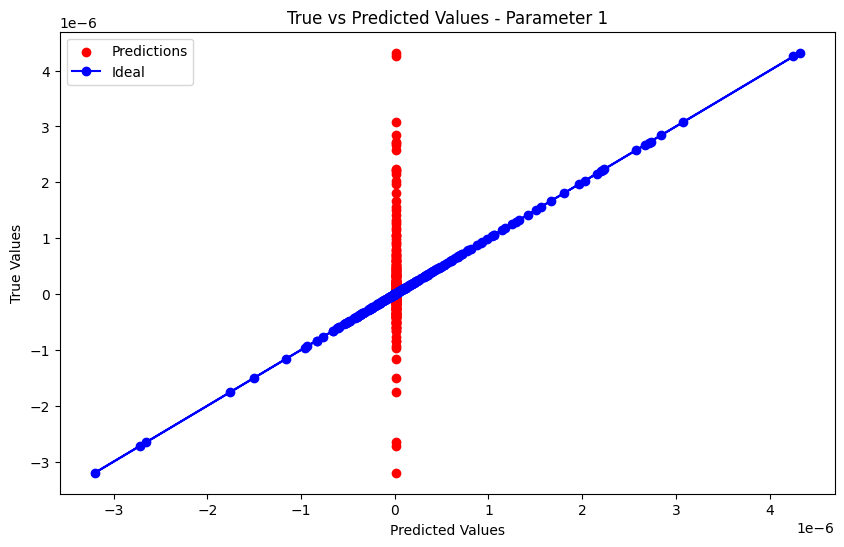

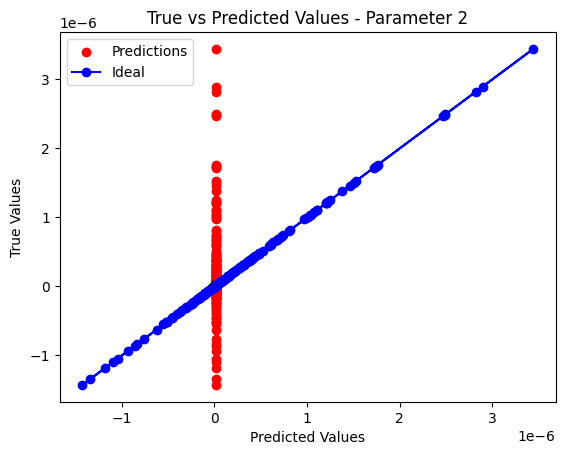

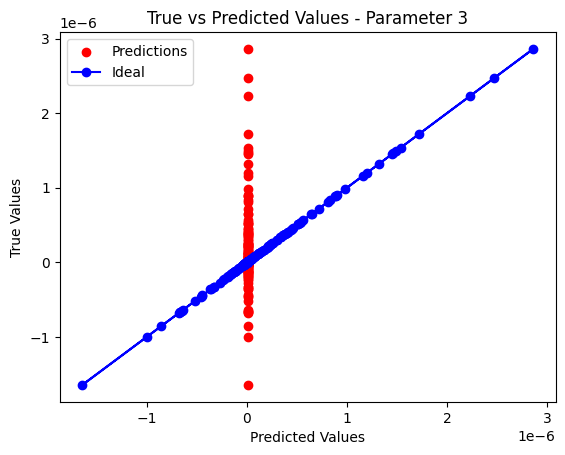

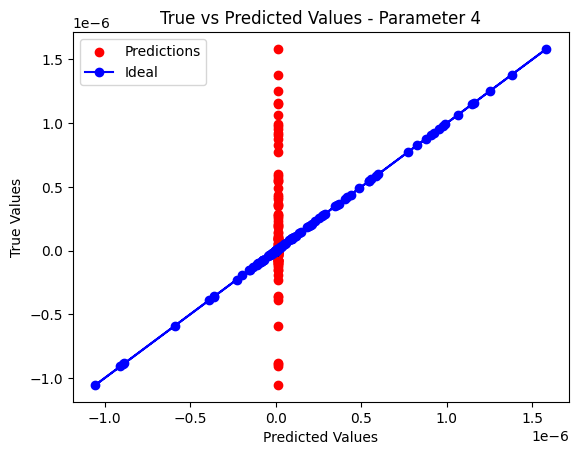

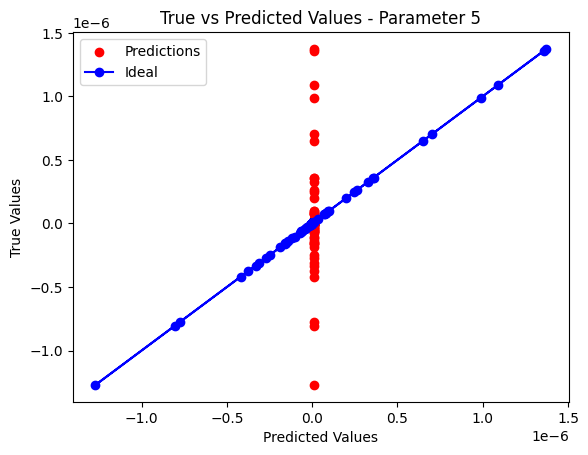

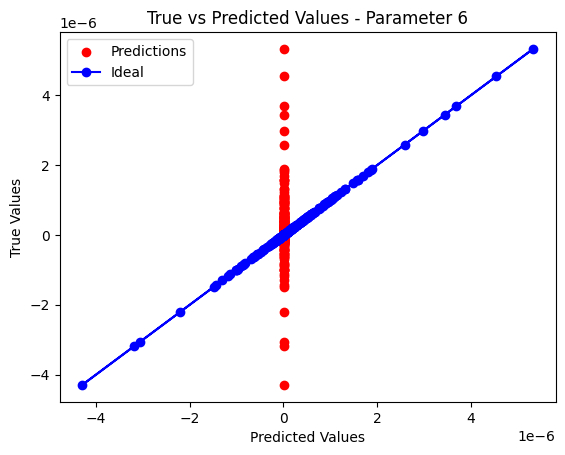

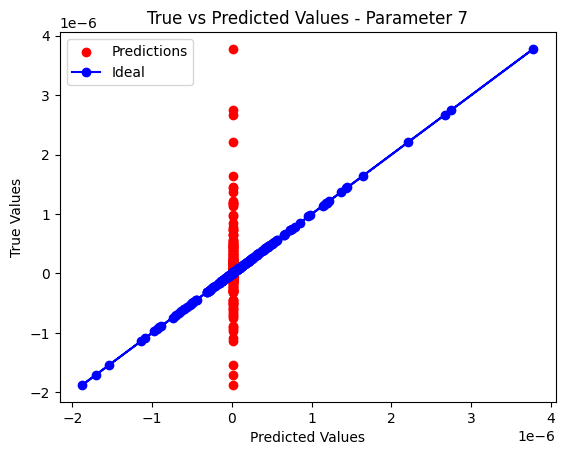

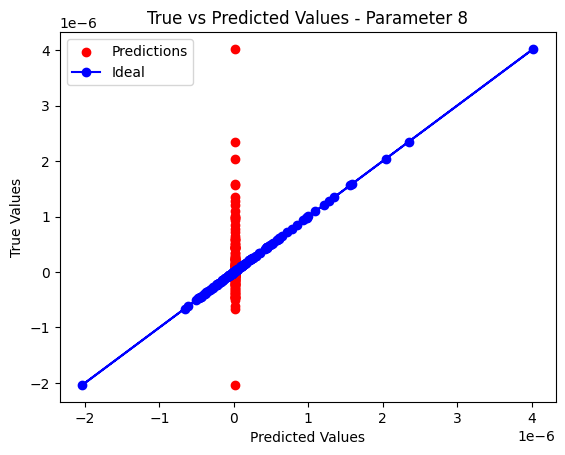

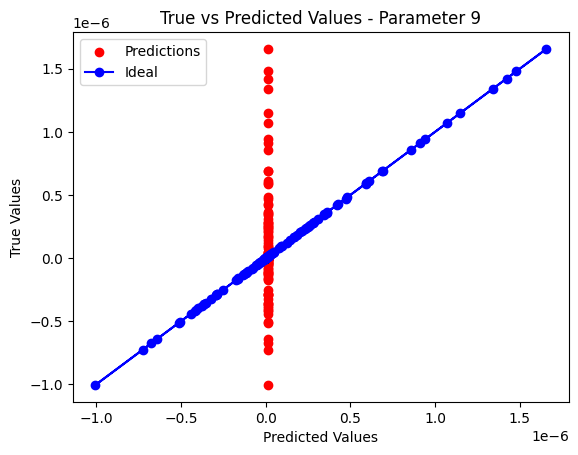

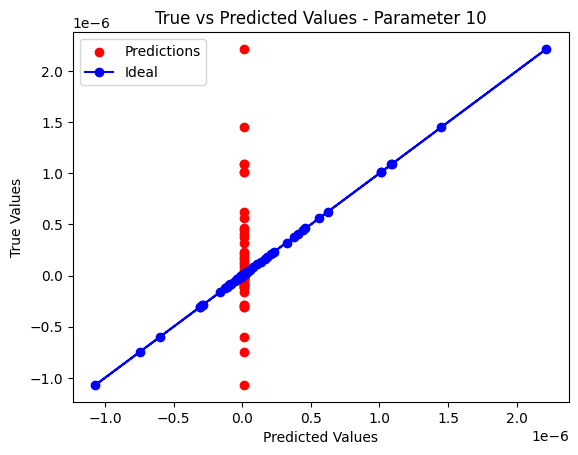

In [49]:
# Plot the predictions vs true values
plt.figure(figsize=(10, 6))
for i in range (10):
    #plt.subplot(5, 2, i + 1)
    plt.scatter(y_pred_df.iloc[:, i], y_test.iloc[:, i], c='r', marker='o', label='Predictions')
    plt.plot(y_test.iloc[:, i], y_test.iloc[:, i], c='b', marker='o', label='Ideal')
    #plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
     #        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'k--', lw=3, label='Ideal')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.title(f'True vs Predicted Values - Parameter {i + 1}')
    plt.legend()
    plt.show()
#plt.tight_layout()
#plt.show()

# COMPARING NAIVE AND TWO FOLD APPROACH

In [50]:
import joblib
# Save the model
joblib.dump(gpr_models, 'gpr_models_noise.pkl')
# Save the scaler
joblib.dump(scaler, 'scaler_noise.pkl')

['scaler_noise.pkl']

In [51]:
gpr_models = joblib.load('gpr_models_noise.pkl')
scaler = joblib.load('scaler_noise.pkl')

### NAIVE APPROACH

In [52]:
import time

In [55]:
nodes = 8
t_depth = 5
graph = nx.erdos_renyi_graph(nodes, 0.5)
qaoa = create_qaoa_circuit(t_depth, nodes, graph, pm)
qaoa.measure_all()
observables = create_observables(graph, nodes)
init_params = [0]*qaoa.num_parameters
qaoa_params = qaoa.assign_parameters(init_params)
start = time.time()
ideal_res = minimize(
        obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
)
end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 14.948845148086548 seconds


In [56]:
ideal_res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.04345703125
        x: [ 4.320e-11 -4.838e-10  8.064e-11 -9.878e-10 -2.419e-10
            -2.938e-10 -2.074e-10  2.736e-10 -5.184e-11 -5.472e-11]
      nit: 2
      jac: [-2.441e+05  6.689e+06 -1.562e+06 -4.102e+06 -1.494e+07
            -5.518e+06 -3.125e+06 -1.855e+06 -3.467e+06 -1.172e+07]
     nfev: 286
     njev: 26
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

### TWO FOLD APPROACH

In [59]:
depth=1
qaoa = create_qaoa_circuit(depth, nodes, graph, pm)
qaoa.measure_all()
observables = create_observables(graph, nodes)
init_params = [0]*qaoa.num_parameters
qaoa_params = qaoa.assign_parameters(init_params)
ideal_res_new = minimize(
        obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
)

In [60]:
ideal_res_new

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0234375
        x: [-4.779e-08 -1.026e-07]
      nit: 3
      jac: [-8.789e+05 -3.174e+06]
     nfev: 84
     njev: 28
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [61]:
arr = []
arr = arr + list(ideal_res_new.x)
arr.append(t_depth)

In [62]:
arr=np.array(arr)

In [63]:
arr

array([-4.77860357e-08, -1.02556184e-07,  5.00000000e+00])

In [64]:
arr.shape

(3,)

In [65]:
X.shape

(1980, 3)

In [66]:
arr=arr.reshape(1,-1)

In [67]:
arr.shape

(1, 3)

In [68]:
#new_data = scaler.transform(arr)
data = arr[0]
predictions = []
for i in range(int(data[2]-1)):
    predictions.append(gpr_models[i].predict(arr))

for i in range(int(data[2]-1)):
    predictions.append(gpr_models[i+5].predict(arr))

In [69]:
predictions

[array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08])]

In [70]:
type(predictions)

list

In [71]:
init_params = predictions
init_params.insert(0, data[0])
init_params.insert(t_depth, data[1])

In [72]:
list(init_params)

[-4.778603574437039e-08,
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 -1.0255618440524889e-07,
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08]),
 array([1.41166495e-08])]

In [73]:
init_params = [item if not isinstance(item, np.ndarray) else item.item() for item in init_params]

In [74]:
init_params

[-4.778603574437039e-08,
 1.4116649516004998e-08,
 1.4116649516004998e-08,
 1.4116649516004998e-08,
 1.4116649516004998e-08,
 -1.0255618440524889e-07,
 1.4116649516004998e-08,
 1.4116649516004998e-08,
 1.4116649516004998e-08,
 1.4116649516004998e-08]

In [75]:
qaoa = create_qaoa_circuit(t_depth, nodes, graph, pm)
qaoa.measure_all()
observables = create_observables(graph, nodes)
qaoa_params = qaoa.assign_parameters(init_params)
start = time.time()
ideal_res_new2 = minimize(
        obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="L-BFGS-B"
)
end = time.time()
elapsed_time_new = end - start
print(f"Elapsed time: {elapsed_time_new} seconds")

Elapsed time: 14.642647743225098 seconds


In [76]:
ideal_res_new2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.04931640625
        x: [ 1.172e-07  1.521e-07  1.257e-07  1.119e-07  1.994e-07
             5.721e-08 -1.518e-08  6.441e-08  1.799e-07  1.525e-07]
      nit: 4
      jac: [ 2.930e+05  9.033e+06  7.715e+06  1.318e+06  9.717e+06
             1.323e+07  3.223e+06 -5.908e+06 -3.516e+06  1.304e+07]
     nfev: 286
     njev: 26
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [77]:
print("number of iterations in naive approach : ", ideal_res.nit)
print("number of iterations in two-fold approach : ", ideal_res_new2.nit)
print("number of seconds in naive approach : ", elapsed_time)
print("number of seconds in two-fold approach : ", elapsed_time_new)

number of iterations in naive approach :  2
number of iterations in two-fold approach :  4
number of seconds in naive approach :  14.948845148086548
number of seconds in two-fold approach :  14.642647743225098


In [78]:
diff=100*(elapsed_time - elapsed_time_new)/elapsed_time
print(f'Reduction of time : {diff}%')

Reduction of time : 2.0483014027384145%
